# Fourier shape representation

In [1]:
# %matplotlib widget
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

# import open3d as o3d
# from open3d import JVisualizer

import numpy as np
from tqdm.notebook import tqdm as tqdm
import torch
import torch.nn as nn
import trimesh
from trimesh.sample import sample_surface
import torch.utils.data as data

## build model & dataset

In [2]:
from network import *

## visualize data

In [3]:
# mesh_path = "./bunny/reconstruction/bun_zipper.ply"
# dataset =GeometryDataset(mesh_path,samples=100000)
# from torch.utils.data import DataLoader
# dataloader = DataLoader(dataset,batch_size=1000, num_workers=4,pin_memory=True)

# mesh=dataset.mesh
# vertices = dataset.pnts
# fig = plt.figure()
# ax = Axes3D(fig)
# # ax.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2]) 
# plot_geeks = ax.scatter(vertices[:, 0], vertices[:,1], vertices[:,2],color='green')
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')
# plt.show()

## init models

In [4]:
torch.set_default_dtype(torch.float32)
model = ImplicitNetwork(d_in=3,d_out=1,dims=[512, 512, 512, 512, 512, 512, 512, 512],bias=0.2,skip_in=[4]).cuda()
sampler = NormalPerPoint(global_sigma=0.1, local_sigma=0.01)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,
    weight_decay=0,
)
model.load_state_dict(torch.load("./checkpoints/model_0072000.pth")["model"])

<All keys matched successfully>

## training sdf for specific mesh

In [5]:
# # plt_groups = {'mnfld_loss_train':[],'grad_loss':[]}
# # plotlosses_model = PlotLosses(groups=plt_groups)
# plotlosses_model = PlotLosses()
# steps=0
# for i in range(1000000):
#     for mnfld_pnts, normals in tqdm(dataloader, leave=False):
#         mnfld_pnts=mnfld_pnts.cuda()
#         normals=normals.cuda()
#         nonmnfld_pnts = sampler.get_points(mnfld_pnts)
#         # forward
#         mnfld_pnts.requires_grad_()
#         nonmnfld_pnts.requires_grad_()
#         mnfld_pred = model(mnfld_pnts)
#         nonmnfld_pred = model(nonmnfld_pnts)
#         mnfld_grad = gradient(mnfld_pnts, mnfld_pred)
#         nonmnfld_grad = gradient(nonmnfld_pnts, nonmnfld_pred)
#         # maniflod_loss
#         mnfld_loss = (mnfld_pred.abs()).mean()
#         # eikonal loss
#         grad_loss = ((nonmnfld_grad.norm(2, dim=-1) - 1) ** 2).mean()
#         # regularize: prevents off-surface locations to create zero-isosurface
#         sdf_global_without_surface = nonmnfld_pred[mnfld_pnts.shape[0] :]
#         reg_loss = torch.exp(
#             -100 * (sdf_global_without_surface.abs())
#         ).mean()

#         loss = (
#             mnfld_loss
#             + 0.1 * grad_loss
#             + 0.1 * reg_loss
#         )
#         # normal loss
#         if False:
#             normals = normals.view(-1, 3)
#             normals_loss = ((mnfld_grad - normals).abs()).norm(2, dim=1).mean()
#             loss = loss + cfg.SOLVER.LOSS.NORMAL_LAMBDA * normals_loss
#         # back propagation
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         steps+=1
#         if steps%100==0:
#             torch.save(model.state_dict(), "./checkpoints/last.pth")
#             plotlosses_model.update({'loss':loss.item(),'mnfld_loss_train':mnfld_loss.item(),'grad_loss':grad_loss.item()}, current_step=steps)
#             plotlosses_model.send()


## get volume and mesh

In [6]:
from plot import plot_surface
RESULOTION=100
mesh,volume = plot_surface(model,path="./results",iteration=72000, shapename="result",resolution=RESULOTION,mc_value=0.,is_uniform_grid=True,verbose=False,
                        save_html=False,
                        save_ply=True,
                        overwrite=True,cube_length=1.5)
print("number of inner points :",(volume<0).sum())
print("number of outer points :",(volume>0).sum())

face_normals incorrect shape, ignoring!


number of inner points : 192972
number of outer points : 807028


## Fourier transform for geometry
### visualize volume

In [7]:
import trimesh
from skimage import measure
def get_mesh(volume):
    verts, faces, normals, values = measure.marching_cubes_lewiner(volume=volume,level=0.)
    meshexport = trimesh.Trimesh(verts, faces, normals, vertex_colors=values)   
    return meshexport

In [8]:
torch.fft.rfftn(torch.from_numpy(volume).cuda(),s=[100,100,100]).shape

torch.Size([100, 100, 51])

### FFT for shape

In [22]:
F=torch.fft.rfftn(torch.from_numpy(volume).cuda(),s=[100,100,100])
F_shift=torch.fft.fftshift(F)
F_low=torch.zeros_like(F_shift)
F_low[10:90,10:90,:51]=F_shift[10:90,10:90,:51]
F_high=F_shift.clone()
F_high[30:70,30:70,:30]=0

### IFFT for shape

In [23]:
f=torch.fft.irfftn(torch.fft.ifftshift(F_shift))
f=torch.real(f).cpu().numpy()

f_low=torch.fft.irfftn(torch.fft.ifftshift(F_low))
f_low=torch.real(f_low).cpu().numpy()

f_high=torch.fft.irfftn(torch.fft.ifftshift(F_high))
f_high=torch.real(f_high).cpu().numpy()

In [24]:
res_mesh=get_mesh(f_low)
_=res_mesh.export("low.ply", "ply")
res_mesh=get_mesh(f_high)
_=res_mesh.export("high.ply", "ply")
res_mesh=get_mesh(f)
_=res_mesh.export("full.ply", "ply")
res_mesh=get_mesh(volume)
_=res_mesh.export("gt.ply", "ply")

face_normals incorrect shape, ignoring!
face_normals incorrect shape, ignoring!
face_normals incorrect shape, ignoring!
face_normals incorrect shape, ignoring!


## Learned Fourier transform for geometry

In [28]:
def fft_f_3(fscale):
    dim=[80,80,51]
    fx = torch.fft.fftfreq(int(100* fscale)) * fscale
    fx = torch.fft.fftshift(fx)
    x_train = torch.stack(torch.meshgrid(fx.reshape(-1), fx.reshape(-1),fx.reshape(-1)), -1)
    F = x_train[50-dim[0]//2:50+dim[0]//2,50-dim[1]//2:50+dim[1]//2,:dim[2]]
    return F

def get_volume(freq,model,volume_shape=[100,100,51]):
    init_F = torch.zeros(volume_shape,dtype=torch.cfloat).cuda()
    v_i,v_j,v_k=volume_shape
    out_ksp = torch.view_as_complex(model(freq.cuda()))
    i,j,k=out_ksp.shape
    init_F[(v_i-i)//2:(v_i+i)//2,(v_j-j)//2:(v_j+j)//2,:k]=out_ksp
    out=torch.fft.irfftn(torch.fft.ifftshift(init_F))*1e+3
    return out
freq=fft_f_3(1.0)

In [31]:
model_kspace=ImplicitNetwork(d_in=3,d_out=2,dims=[512, 512,512,512, 512,512],geometric_init=False,multires=128).cuda()
training_steps=100000
optimizer = torch.optim.Adam(
    model_kspace.parameters(),
    lr=0.0005,
    weight_decay=0,
)
volume_gt=torch.from_numpy(volume).cuda()

## Training

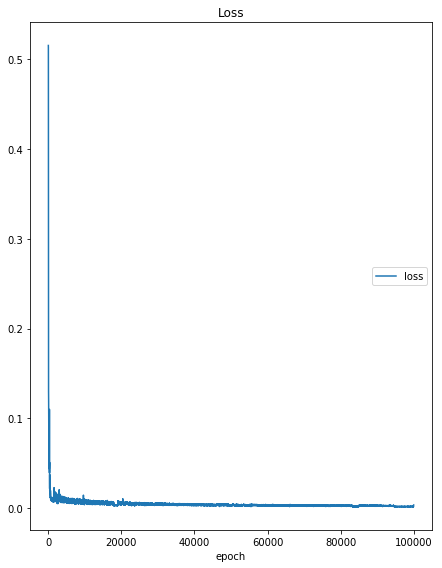

Loss
	loss             	 (min:    0.002, max:    0.515, cur:    0.004)


In [32]:
plotlosses_model = PlotLosses()
optimizer = torch.optim.Adam(
    model_kspace.parameters(),
    lr=0.0005,
    weight_decay=0,
)
loss_fcn=nn.L1Loss(reduction="mean")
for i in tqdm(range(training_steps), desc='train iter', leave=False):
    volume_out=get_volume(freq,model_kspace)
#     loss=torch.mean(torch.abs(volume_out-volume_gt))
    loss=loss_fcn(volume_out,volume_gt)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%10==0:
#         torch.save(model_kspace.state_dict(), "./checkpoints/model_kspace.pth")
        plotlosses_model.update({'loss':loss.item()}, current_step=i)
        plotlosses_model.send()
    if i%200==0:
        _=get_mesh(volume_out.cpu().detach().numpy()).export("learned.ply", "ply")


In [ ]:
get_volume(freq,model_kspace)

In [18]:
_=get_mesh(volume_out.cpu().detach().numpy()).export("learned.ply", "ply")

face_normals incorrect shape, ignoring!


In [ ]:
volume_shape=[100,100,51]
init_F = torch.zeros(volume_shape,dtype=torch.cfloat).cuda()
v_i,v_j,v_k=volume_shape
F=model_kspace(freq.cuda())
out_ksp = torch.view_as_complex(F)
i,j,k=out_ksp.shape
init_F[(v_i-i)//2:(v_i+i)//2,(v_j-j)//2:(v_j+j)//2,:k]=out_ksp
out=torch.fft.irfftn(torch.fft.ifftshift(init_F))

In [ ]:
volume_out.max()

In [ ]:
out_ksp